# Ensemble Learning and Random Forest

## Voting Classifiers:

The following code creates and trains a voting classifier in Scikit-Learn, composed of
three diverse classifiers (the training set is the moons dataset)

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting="hard")

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let’s look at each classifier’s accuracy on the test set:

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There we have it! The voting classifier slightly outperforms all the individual
classifiers.

### Soft Voting:

All you need to do is replace `voting="hard"` with
`voting="soft"` and ensure that all classifiers can estimate class probabilities. This is
not the case for the SVC class by default, so you need to set its `probability`
hyperparameter to `True` (this will make the SVC class use cross-validation to estimate
class probabilities, slowing down training, and it will add a `predict_proba()` method).

In [4]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting="soft")

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting

### Bagging and Pasting in Scikit Learn

Scikit-Learn offers a simple API for both bagging and pasting with the
`BaggingClassifier` class (or `BaggingRegressor` for regression).

The following code trains an ensemble of 500 Decision Tree classifiers: each is trained on 100 training
instances randomly sampled from the training set with replacement (this is an example
of bagging, but if you want to use pasting instead, just set `bootstrap=False`). The
`n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and
predictions (–1 tells Scikit-Learn to use all available cores):

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


**NOTE:**

The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base
classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case
with Decision Tree classifiers.

Below graph compares the decision boundary of a single Decision Tree with the decision
boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on
the moons dataset. As we can see, the ensemble’s predictions will likely generalize
much better than the single Decision Tree’s predictions: the ensemble has a comparable
bias but a smaller variance (it makes roughly the same number of errors on the training
set, but the decision boundary is less irregular)

In [17]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:,0][y==0], X[:,1][y==0], "yo", alpha=alpha)
    plt.plot(X[:,0][y==1], X[:,1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

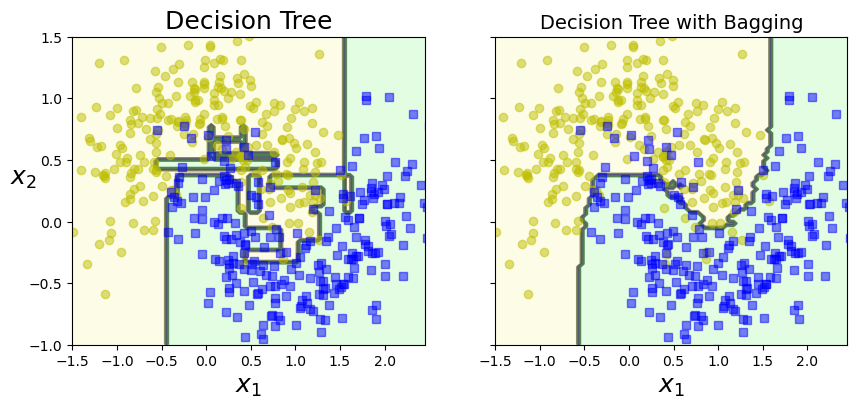

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=18)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

Overall, bagging often results in better models, which explains why
it is generally preferred. However, if we have spare time and CPU power, we can use
cross-validation to evaluate both bagging and pasting and select the one that works best.

### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a `BaggingClassifier` samples *m*
training instances with replacement (`bootstrap=True`), where *m* is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor.6 The remaining 37% of the training instances that are not
sampled are called *out-of-bag* (oob) instances. Note that they are not the same 37% for
all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. We can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, we can set `oob_score=True` when creating a BaggingClassifier to
request an automatic oob evaluation after training. The following code demonstrates
this. The resulting evaluation score is available through the `oob_score_` variable:

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, oob_score=True, random_state=40
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

According to this oob evaluation, this BaggingClassifier is likely to achieve about
89.86% accuracy on the test set. Let’s verify this:

In [20]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

We get 91.2% accuracy on the test set—close enough!

The oob decision function for each training instance is also available through the
`oob_decision_function_` variable. In this case (since the base estimator has a
`predict_proba()` method), the decision function returns the class probabilities for
each training instance. For example, the oob evaluation estimates that the first training
instance has a 67.72% probability of belonging to the positive class (and 32.27% of
belonging to the negative class):

In [21]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. Sampling is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work same as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features. 

This technique is particularly useful when dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the `Random Patches Method`. Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features=True` and/or `max_features` to a value smaller than ``1.0`) is called `Random Subspaces Method`.

Sampling features results in even more predictor diversity, trading a bit more bias for a
lower variance.

## Random Forests

Random Forests is an ensemble of Decision Trees, generally trained via bagging method (or sometimes pasting), typically with `max_samples` set to the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, we can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees (similarly, there is `RandomForestRegressor` class for regression tasks).

The following code uses all available CPU cores to train a Random Forest Classifier with 500 trees (each limited to maximum 16 nodes). 

In [22]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With few exceptions, `RandomForestClassifier` has all hyperparameters of `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensembling. 

The Random Forest Algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting the node, it searches for the best feature among a random subsets of features. The algorithm results in greater tree diversity, which (again) trades a higher bias for lower variance, generally yielding an overall better model. 

The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

np.sum(y_pred == y_pred_rf) / len(y_pred) # very similar predictions

0.976

### Extra Trees

When we are growing a tree in a Random Forest, at each node only a random subset of features is considered for splitting. It is possible to make trees even more random by using random thresholds for each feature rather than searching for best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is called an `Extremely Randomized Trees` ensemble (or Extra-Trees for short). Once again this technique trade more bias for lower variance. It also makes Extra-Trees much faster to train than Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

We can create Extra-Trees classifier using Scikit-Learn's `ExtraTreesClassfier` class. Its API is identical to the `RandomForestClassifier` class. Similarly, the `ExtraTreeRegressor` class has the same API as `RandomForestRegressor` class.

**TIP:**

It is hard to tell in advance whether a `RandomForestClassifier` will perform better or worse than an `ExtraTreeClassifier`. Generally, the only way to know is to try both and compare them using cross-validation (tuning the hyperaparameters using grid search).

### Feature Importance

Yet another quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on an average (across all trees in the forest). Most precisely, it is a weighted average, where each node's weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. We can access the result using `feature_importances_` variable. For example, the following code trains a `RandomForestClassifier` on iris dataset and outputs each feature's importance. It seems that the most important features are petal length (43%) and petal width (45%), while sepal length and width are rather unimportant in comparison (9.3% and 2.4% respectively).

In [32]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09343888924274169
sepal width (cm) 0.024896821603119085
petal length (cm) 0.4285461897232297
petal width (cm) 0.4531180994309095


Similarly, if we train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in below:

In [33]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

/home/dell/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [34]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [35]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

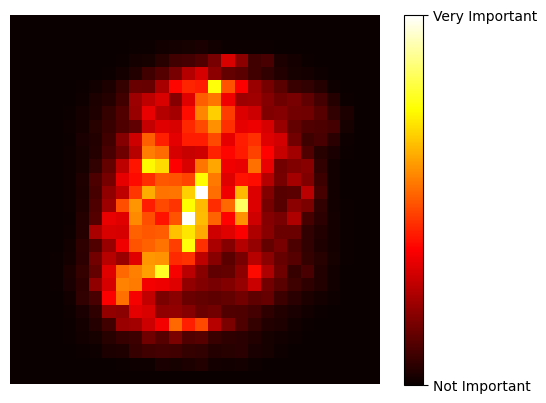

In [38]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Very Important'])

plt.show()

Random Forests are very handy to get a quick understanding of what features actually
matter, in particular if we need to perform feature selection.

## Boosting

### AdaBoost

The following code trains an AdaBoost classifier based on 200 *Decision Stumps* using
Scikit-Learn’s `AdaBoostClassifier` class (as we might expect, there is also an
`AdaBoostRegressor` class). A Decision Stump is a Decision Tree with `max_depth=1` - in other words, a tree composed of single decision node plus two leaf nodes. This is the default base estimator for `AdaBoostClassifier` class:

In [39]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, 
    random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

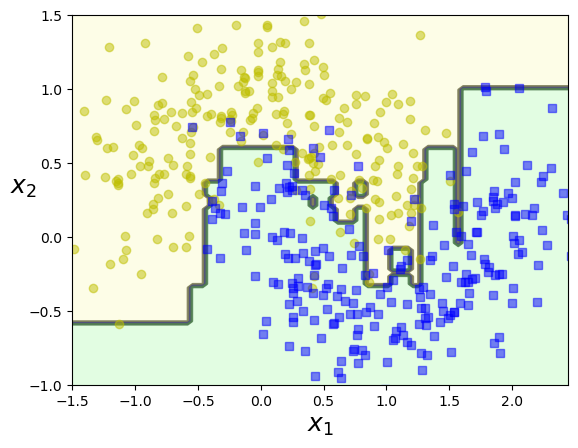

In [40]:
plot_decision_boundary(ada_clf, X, y)

**TIP:**

If our AdaBoost ensemble is overfitting the training set, we can try reducing the number of
estimators or more strongly regularizing the base estimator.

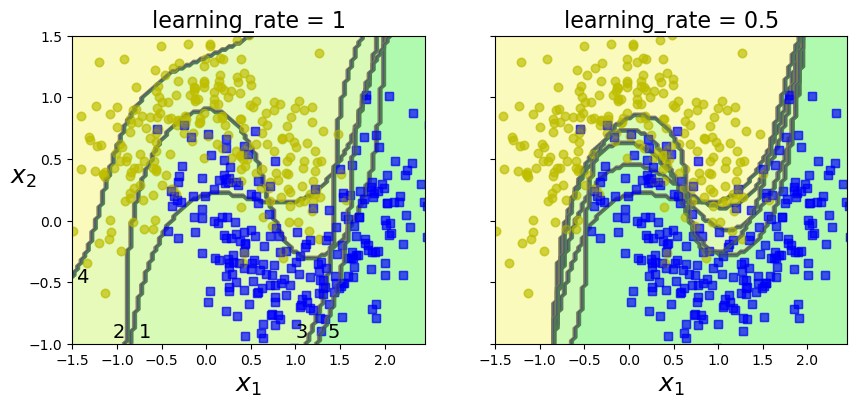

In [45]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights*m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1-r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

Above graph shows the decision boundaries of five consecutive predictors on the moons
dataset (in this example, each predictor is a highly regularized SVM classifier with an
RBF kernel). This is just for illustrative purpose. SVMs are generally not good base predictors for AdaBoost; they are slow and tend to unstable with it. 

The first classifier gets many instances wrong, so their weights get
boosted. The second classifier therefore does a better job on these instances, and so on.
The plot on the right represents the same sequence of predictors, except that the
learning rate is halved (i.e., the misclassified instance weights are boosted half as much
at every iteration). As we can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bagging
or pasting, except that predictors have different weights depending on their overall
accuracy on the weighted training set.

**Warning :**

There is one important drawback to this sequential learning technique: it cannot be parallelized (or
only partially), since each predictor can only be trained after the previous predictor has been trained
and evaluated. As a result, it does not scale as well as bagging or pasting.

### Gradient Boosting

Let's go through simple regression example, using Decision Trees as the base predictors (ofcourse, Gradient Boosting also works great with regression tasks). This is called *Gradient Tree Boosting*, or *Gradient Boosted Regression Trees* (GBRT). First let's fit a `DecisionTreeRegressor` to training set (for example, noisy quadratic training set):

In [61]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now Let's train a `DecisionTreeRegressor` on the residual errors made by the first tree regressor.

In [63]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:

In [49]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [64]:
X_new = np.array([[0.8]])

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees.

In [65]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [66]:
y_pred

array([0.55718137])

In [67]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

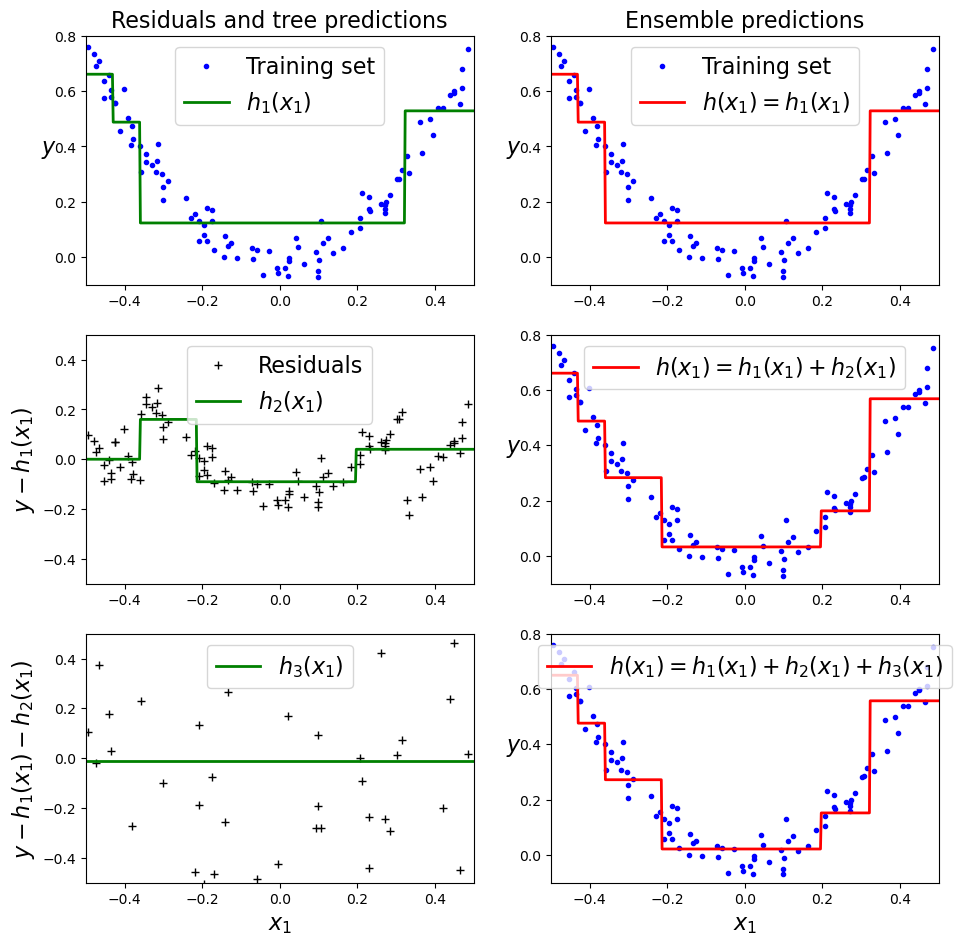

In [68]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

Above graph represents the predictions of three trees we trained in the left column, and the ensemble's predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly same as first tree's predictions. In second row, a new tree is trained on the residual errors of the first tree. On right, we can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are
added to the ensemble. 

A simpler way to train GBRT ensembles is to use Scikit-Learn’s
`GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`,
`min_samples_leaf`), as well as hyperparameters to control the ensemble training, such
as the number of trees (`n_estimators`). The following code creates the same ensemble
as the previous one:

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1)
gbrt.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=3)

In [70]:
gbrt.predict(X_new)

array([0.33682158])

The `learning_rate` hyperparameter scales the contribution of each tree. If we set it to
a low value, such as 0.1, we will need more trees in the ensemble to fit the training set,
but the predictions will usually generalize better. This is a regularization technique
called *shrinkage*.

Below code shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

In [71]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

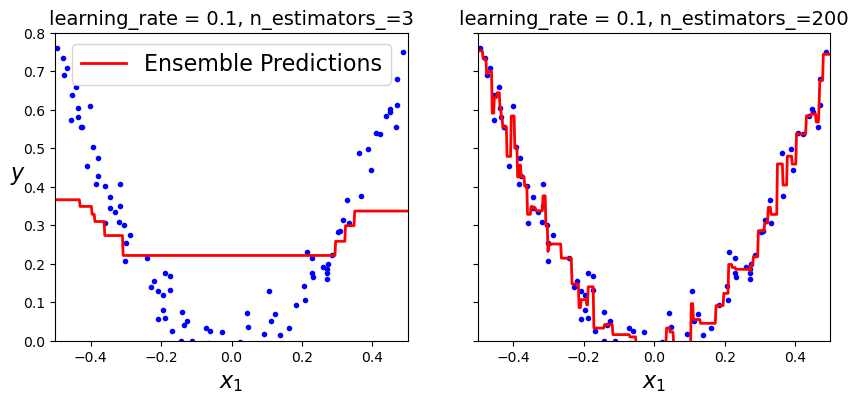

In [75]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4) , sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, 0.0, 0.8], label="Ensemble Predictions")
plt.title("learning_rate = {}, n_estimators_={}".format(gbrt.learning_rate, gbrt.n_estimators_), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, 0.0, 0.8])
plt.title("learning_rate = {}, n_estimators_={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators_), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In order to find optimal number of trees , we can using early stopping. A simple way to implement is this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two tree, etc.). 

The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

In [92]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [93]:
min_error = np.min(errors)

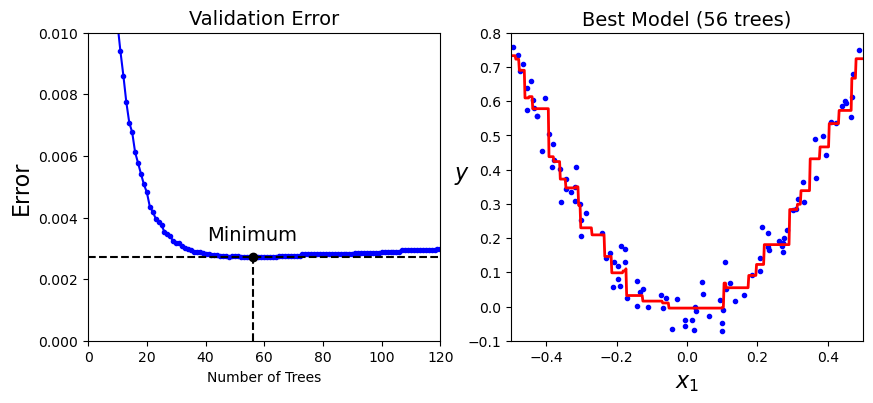

In [97]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0,120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of Trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation Error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best Model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

The validation errors are represented on the left of above graph, and the best model’s
predictions are represented on the right.

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). We can do so by setting `warm_start=True`, which makes Scikit-
Learn keep existing trees when the fit() method is called, allowing incremental
training. 

The following code stops training when the validation error does not improve
for five iterations in a row:

In [98]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [99]:
print(gbrt.n_estimators)

61


In [100]:
print("Minimum validation MSE: " , min_val_error)

Minimum validation MSE:  0.002712853325235463


The GradientBoostingRegressor class also supports a `subsample` hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instances,
selected randomly. As we can probably guess by now, this technique trades a higher
bias for a lower variance. It also speeds up training considerably. This is called
`Stochastic Gradient Boosting`.

**NOTE:**

It is possible to use Gradient Boosting with other cost functions. This is controlled by the loss
hyperparameter.

It is worth noting that an optimized implementation of Gradient Boosting is available in
the popular Python library `XGBoost`, which stands for Extreme Gradient Boosting. XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [101]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

XGBoost also offers several nice features, such as automatically taking care of early
stopping:

In [103]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE: ", val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE:  0.002630868681577655


/home/dell/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Should definitely explore later!!

## Stacking

## Exercises

### 8.

Load the MNIST data, and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [104]:
# MNIST dataset is already loaded earlier

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

In [105]:
# Training various classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)

In [108]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf]

for estimator in estimators:
    print("Training the ", estimator)
    estimator.fit(X_train, y_train)

Training the  RandomForestClassifier(random_state=42)
Training the  ExtraTreesClassifier(random_state=42)
Training the  LinearSVC(max_iter=100, random_state=42, tol=20)


In [109]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859]

Linear SVM is far outperformed by other classifier

In [ ]:
# combining into an ensemble

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf)
]